In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from scipy.optimize import curve_fit

from modules.numeric import *

In [150]:
L = 200
N = 2048
dx = 2*L/(N - 1)
dt = 4e-2
X0 = 5

phi4 = Phi4()

def y0(x, v):
    return np.stack((
        phi4.kink(x + X0, 0, v) - phi4.kink(x - X0, 0, v/2) - 1,
        phi4.kink_dt(x + X0, 0, v) - phi4.kink_dt(x - X0, 0, v/2)
    ))

collider = Wave(
    x_grid= (-L, L, N), 
    dt= dt, 
    order= 4,
    y0= y0,
    F= phi4.diff,
    boundaries=[Reflective(4)]*2
)

(-25.0, 25.0)

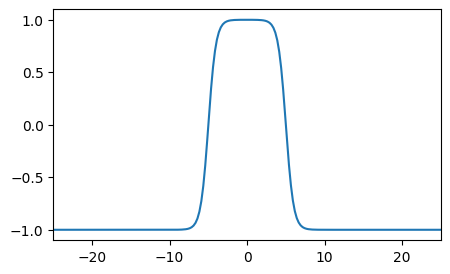

In [151]:
x = np.linspace(-25, 25, 200)
plt.figure(figsize=(5, 3))
plt.plot(x, y0(x, 0.2)[0])
plt.xlim(x.min(), x.max())

In [152]:
def run_and_plot(ax=None, **kwargs):
    lat, Y = collider.run(**kwargs)
    if ax == None: ax = plt.gca()
    im = ax.imshow(Y[:, 0].T, cmap='seismic', extent=lat.extent(), aspect='auto', origin='lower')
    return im, lat, Y

Text(0.5, 1.0, '$\\phi$')

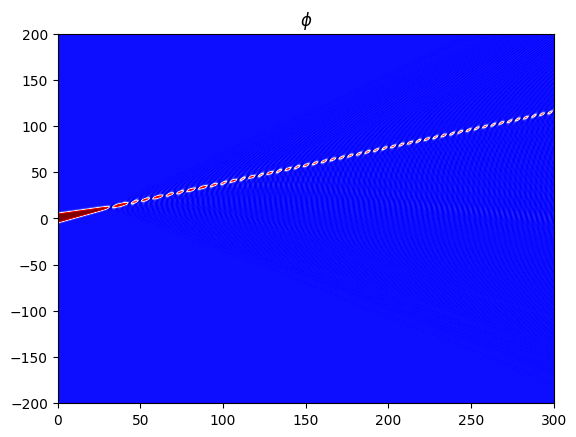

In [153]:
u = []
im, lat, Y = run_and_plot(t_final=300, v=0.5) #, event=catch(u, argnearest(collider.x, 0)))
y = Y[:, 0].T
plt.title(r'$\phi$')

Text(0.5, 1.0, '$g = 1 - \\phi^2$')

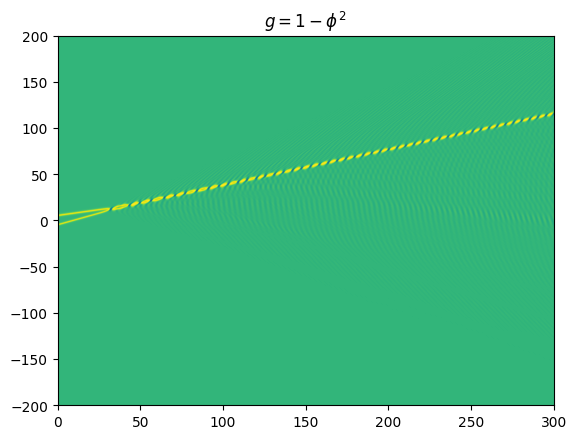

In [154]:
plt.imshow(1 - y**2, extent=lat.extent(), aspect='auto', origin='lower')
plt.title(r'$g = 1 - \phi^2$')

Text(0.5, 1.0, '$g > 0.5\\cdot \\max(g)$')

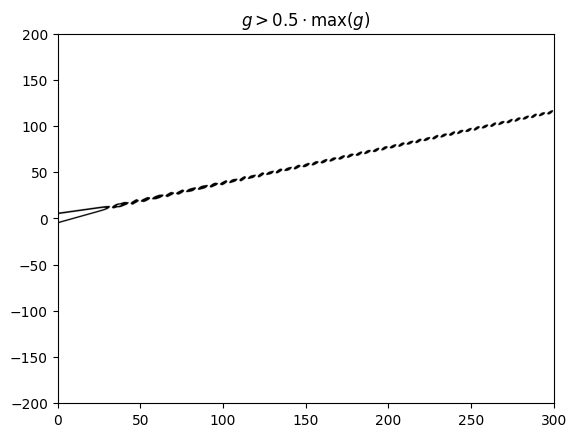

In [155]:
g = 1 - y**2
highpass = g > g.max() * 0.5
plt.imshow(highpass, extent=lat.extent(), aspect='auto', origin='lower', cmap='gray_r')
plt.title(r'$g > 0.5\cdot \max(g)$')

In [156]:
def linear(t, a):
    return a*t

x = np.arange(y.shape[0])*dx - L
trajectory = []
for i, row in enumerate(highpass.T):
    filtered = x[row]
    if len(filtered) > 0:
        center = (filtered.min() + filtered.max())/2
        trajectory.append((i*dt, center))
T, X = np.transpose(trajectory)
(v,), _ = curve_fit(linear, T, X)
v,

(0.3825793727601745,)

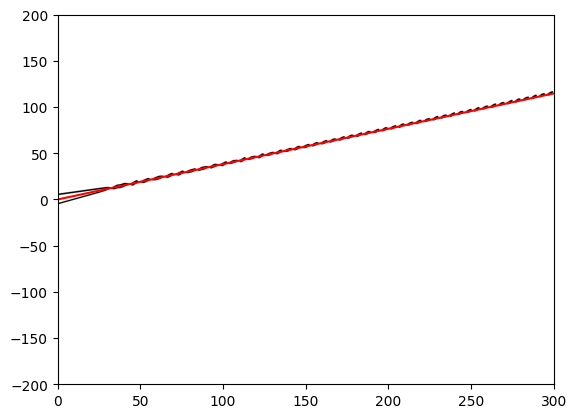

In [157]:
plt.imshow(highpass, extent=lat.extent(), aspect='auto', origin='lower', cmap='gray_r')
plt.axline((0, 0), slope=v, c='r')

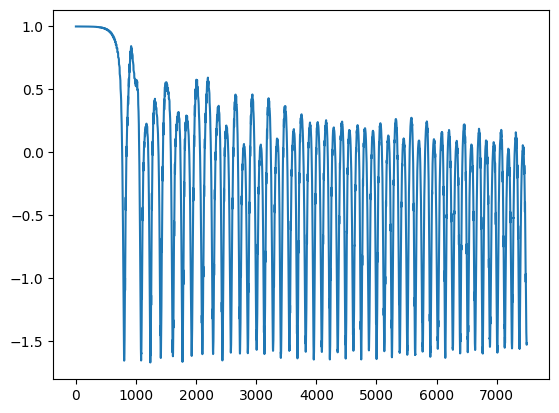

In [158]:
osc = [u[np.argmin(np.abs(x - linear(i*dt, v)))] for i, u in enumerate(y.T)]
plt.plot(osc)

Text(0.5, 0, '$\\omega$')

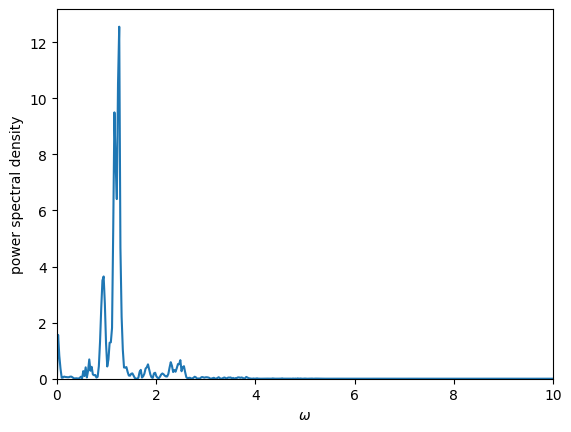

In [159]:
f, Pxx = periodogram(osc[1000:], 1/dt)
omega = 2*np.pi*f

plt.plot(omega, Pxx)
plt.ylim(bottom=0)
plt.xlim(0, 10)
plt.ylabel('power spectral density')
plt.xlabel(r'$\omega$')

Text(0.5, 0, '$\\omega$')

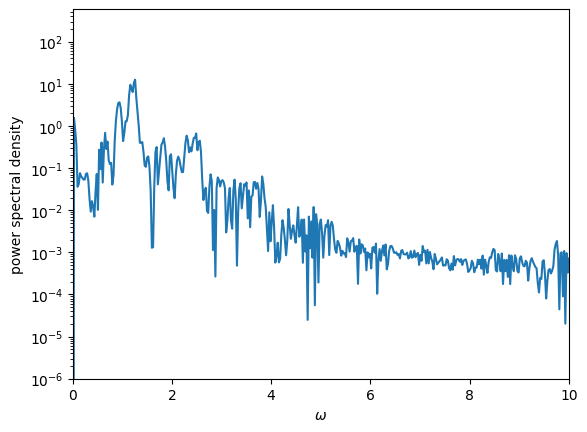

In [160]:
plt.plot(omega, Pxx)
plt.semilogy()
plt.ylim(bottom=1e-6)
plt.xlim(0, 10)
plt.ylabel('power spectral density')
plt.xlabel(r'$\omega$')

In [13]:
dt = DT

Text(0.5, 0, '$\\omega$')

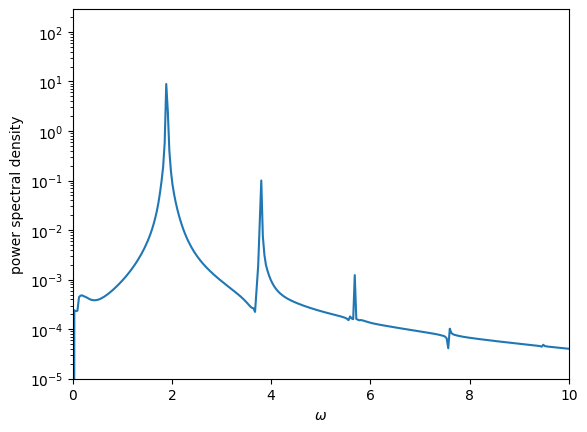

In [23]:
f, Pxx = periodogram(u, 1/dt)
omega = 2*np.pi*f

plt.plot(omega, Pxx)
plt.semilogy() # escala logarítimica
plt.ylim(bottom=1e-5)
plt.xlim(0, 10)
plt.ylabel('power spectral density')
plt.xlabel(r'$\omega$')

In [10]:
def catch(u, index):
    def _wrapped(t, Y):
        y, _ = Y
        u.append(y[index])
    return _wrapped

def combine(*events):
    def _wrapped(t, Y):
        for event in events:
            event(t, Y)
    return _wrapped

In [111]:
Ns = 200
counter = Value('i', 0)
CM = argnearest(collider.x, 0)
DT = argnearest(collider.x, 20)
f_max = Value('f', 0)
def _task(A0):
    counter.value += 1
    print(f'{(counter.value/Ns*100):.2f}%\r', end='')

    u1 = []
    u2 = []
    collider.run(t_final=200, A0=A0, sigma=10, stack=False, event=combine(catch(u1, CM), catch(u2, DT)))
    f1, Pxx1 = periodogram(u1, 1/DT, nfft=len(u1))
    f2, Pxx2 = periodogram(u2, 1/DT, nfft=len(u2))
    f_max.value = max(f1.max(), f2.max())
    return Pxx1, Pxx2

A0s = np.linspace(0, 1, Ns + 2)[1:-1]
with Pool(int(0.7*cpu_count())) as pool:
    Pxx_map = pool.map(_task, A0s)
Pxx_map = np.stack(Pxx_map)
# freqs, _ = periodogram(np.zeros(Pxx_map.shape[-1]), 1/DT)
df1 = pd.DataFrame(Pxx_map[:, 0])
df2 = pd.DataFrame(Pxx_map[:, 1])

(0.0, 300.0)

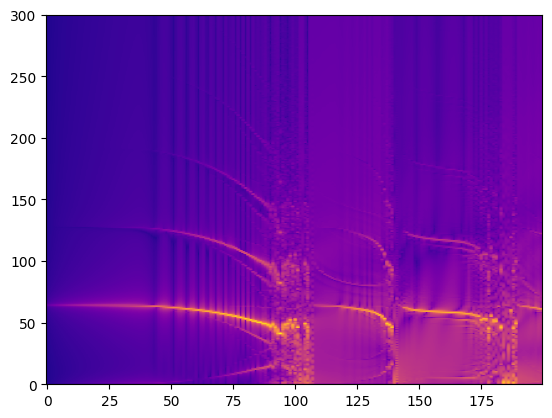

In [115]:
plt.imshow(df1.values.T, aspect='auto', cmap='plasma', origin='lower', norm=colors.PowerNorm(0.15))
plt.ylim(0, 300)

(0.0, 300.0)

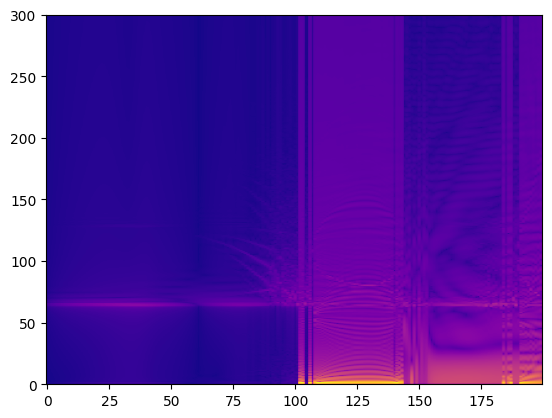

In [118]:
plt.imshow(df2.values.T, aspect='auto', cmap='plasma', origin='lower', norm=colors.PowerNorm(0.15))
plt.ylim(0, 300)

In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from matplotlib import colors

from multiprocessing import Pool, Value
from os import cpu_count

from modules.numeric import *

In [42]:
L = 200
N = 2048
DX = 2*L/(N - 1)
DT = 4e-2
X0 = 20

phi4 = Phi4()

def y0(x, A0, sigma, f):
    return np.stack((
        A0*np.exp(-x**2/sigma)*np.cos(2*np.pi*f*x)/2 + 1,
        np.full(x.shape, 0)
    ))

collider = Wave(
    x_grid= (-L, L, N), 
    dt= DT, 
    order= 4,
    y0= y0,
    F= phi4.diff,
    boundaries=[Reflective(4)]*2
)

(-25.0, 25.0)

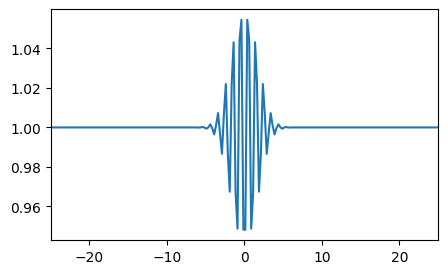

In [43]:
x = np.linspace(-25, 25, 200)
plt.figure(figsize=(5, 3))
plt.plot(x, y0(x, 0.15, 5, 5)[0])
plt.xlim(x.min(), x.max())

In [55]:
def run_and_plot(ax=None, **kwargs):
    lat, Y = collider.run(**kwargs)
    if ax == None: ax = plt.gca()
    im = ax.imshow(Y[:, 0].T, cmap='twilight', extent=lat.extent(), aspect='auto', origin='lower')
    return im

(-50.0, 50.0)

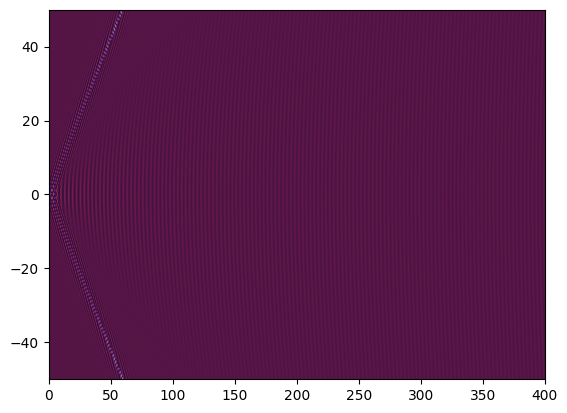

In [66]:
run_and_plot(t_final=400, A0=1, sigma=20, f=0.5)
plt.ylim(-50, 50)

In [ ]:
def catch(u, index):
    def _wrapped(t, Y):
        y, _ = Y
        u.append(y[index])
    return _wrapped

def combine(*events):
    def _wrapped(t, Y):
        for event in events:
            event(t, Y)
    return _wrapped

In [ ]:
Ns = 200
counter = Value('i', 0)
CM = argnearest(collider.x, 0)
DT = argnearest(collider.x, 20)
f_max = Value('f', 0)
def _task(A0):
    counter.value += 1
    print(f'{(counter.value/Ns*100):.2f}%\r', end='')

    u1 = []
    u2 = []
    collider.run(t_final=200, A0=A0, sigma=10, stack=False, event=combine(catch(u1, CM), catch(u2, DT)))
    f1, Pxx1 = periodogram(u1, 1/DT, nfft=len(u1))
    f2, Pxx2 = periodogram(u2, 1/DT, nfft=len(u2))
    f_max.value = max(f1.max(), f2.max())
    return Pxx1, Pxx2

A0s = np.linspace(0, 1, Ns + 2)[1:-1]
with Pool(int(0.7*cpu_count())) as pool:
    Pxx_map = pool.map(_task, A0s)
Pxx_map = np.stack(Pxx_map)
# freqs, _ = periodogram(np.zeros(Pxx_map.shape[-1]), 1/DT)
df1 = pd.DataFrame(Pxx_map[:, 0])
df2 = pd.DataFrame(Pxx_map[:, 1])

(0.0, 300.0)

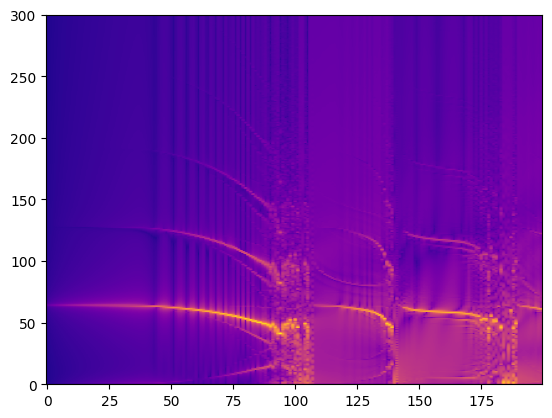

In [ ]:
plt.imshow(df1.values.T, aspect='auto', cmap='plasma', origin='lower', norm=colors.PowerNorm(0.15))
plt.ylim(0, 300)

(0.0, 300.0)

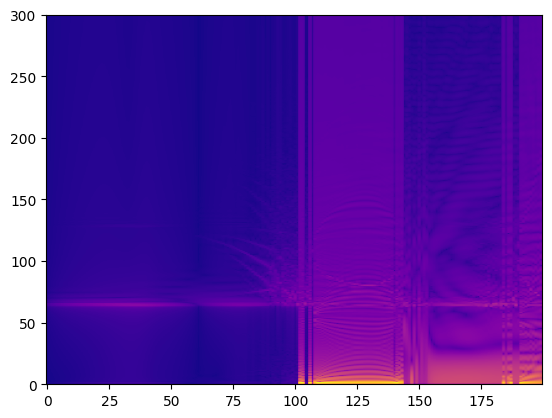

In [ ]:
plt.imshow(df2.values.T, aspect='auto', cmap='plasma', origin='lower', norm=colors.PowerNorm(0.15))
plt.ylim(0, 300)

In [133]:
from scipy.signal import periodogram

dt = 0.01
N = 2000
t = np.arange(N)*dt

f1 = 0.2
f2 = 1
y = np.sin(2*np.pi*f1*t)*np.sin(2*np.pi*f2*t)

freqs, power = periodogram(t, 1/dt)

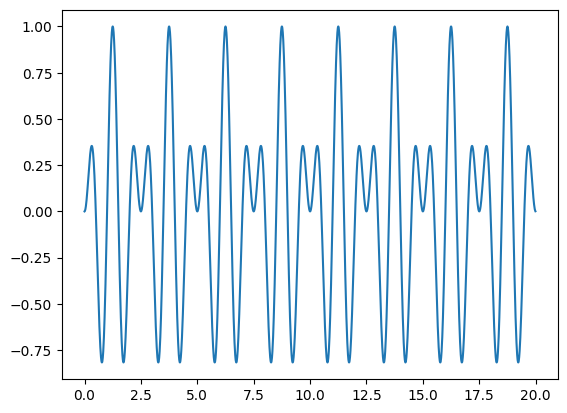

In [134]:
plt.plot(t, y)

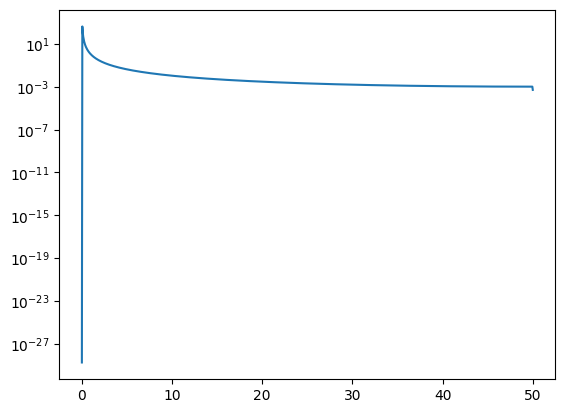

In [135]:
plt.semilogy(freqs, power)
# plt.ylim(bottom=1e-3)
# plt.xlim(0, 1)